In [45]:
import os
# os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
# os.environ["CUDA_VISIBLE_DEVICES"] = "1"

import pickle
from glob import glob
import numpy as np
import torch
import torch.nn as nn
import pandas as pd
import time
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch.optim as optim
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [46]:
print(device)

cuda


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [12]:
os.chdir('/content/drive/MyDrive/CSE-251B-Project')
!ls

 Ashwin				        Questions.gdoc
 data				        rasterized_data
 Data_Manipulation.ipynb	       'Relevant Papers.gdoc'
 Dev				       'RNN_LSTM (2).ipynb'
 Ideas.gdoc			        sample_submission.csv
'Lit Review of Related Papers.gsheet'   Tracked_Only_Data
 Load_Argoverse_Data_Public.ipynb       train
 Papers				        training_samples.p
'Preprocessing Ideas.gdoc'	        ucsd-cse-251b-class-competition.zip
'Project Presentation.gslides'	        val_samples.p


In [47]:
class MLPNet(nn.Module):
    def __init__(self, 
                 in_dim, # input dimension
                 out_dim, # output dimension
                 hidden_dim, # hidden dimension
                 num_layers # number of layers
                ):
        
        super(MLPNet, self).__init__()
        
        self.model = [nn.Linear(in_dim, hidden_dim), nn.ReLU()]
        
        for i in range(num_layers-2):
            self.model += [nn.Linear(hidden_dim, hidden_dim), nn.ReLU()]
        
        self.model += [nn.Linear(hidden_dim, out_dim)]
        
        self.model = nn.Sequential(*self.model)
        
    def forward(self, inp):
        
        # Flatten the last two dimensions
        inp = inp.reshape(inp.shape[0], -1)
        
        out = self.model(inp)
        
        #bz x outputlength x 2
        return out.reshape(inp.shape[0], -1, 2)

In [48]:
class MyLSTM(nn.Module):
    def __init__(self, input_size, output_size, hidden_dim, n_layers):
        super(MyLSTM, self).__init__()

        # Defining some parameters
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers

        #Defining the layers
        self.fc1 = nn.Linear(input_size, input_size)
        # RNN Layer
        self.lstm = nn.LSTM(input_size, hidden_dim, n_layers, batch_first=True)   
        # Fully connected layer
        self.fc2 = nn.Linear(hidden_dim, output_size)
    
    def forward(self, x):
        batch_size = x.size(0)

        # Flatten the last two dimensions
        x = x.reshape(x.shape[0], -1)
        
        #First linear layer
        transform = self.fc1(x)

        #Initializing hidden state for first input using method defined below
        h_t, c_t = self.init_hidden(batch_size)

        # Passing in the input and hidden state into the model and obtaining outputs
        out, (h_t, c_t) = self.lstm(transform, (h_t, c_t))
        
        # Reshaping the outputs such that it can be fit into the fully connected layer
        out = out.contiguous().view(-1, self.hidden_dim)
        out = self.fc2(out)
        
        return out, (h_t, c_t)
    
    def init_hidden(self, batch_size):
        # This method generates the first hidden state of zeros which we'll use in the forward pass
        h_0 = torch.zeros(self.n_layers, batch_size, self.hidden_dim).to(device)
        c_0 =  torch.zeros(self.n_layers, batch_size, self.hidden_dim).to(device)       
         # We'll send the tensor holding the hidden state to the device we specified earlier as well
        return h_0, c_0

In [49]:
class ArgoverseDataset(torch.utils.data.Dataset):
    """Dataset class for Argoverse"""
    
    def __init__(self, 
                 data_path,
                 sample_indices):
        super(ArgoverseDataset, self).__init__()
        
        self.data_path = data_path
        self.sample_indices = sample_indices
        self.pkl_list = glob(os.path.join(self.data_path, '*'))
        print(self.pkl_list)
        self.pkl_list.sort()
        
    def __len__(self):
        return len(self.sample_indices)

    def __getitem__(self, idx):
        
        # Load one scene
        pkl_path = self.pkl_list[self.sample_indices[idx]]
        with open(pkl_path, 'rb') as f:
            scene = pickle.load(f)
            
        # the index of agent to be predicted 
        pred_id = np.where(scene["track_id"] == scene['agent_id'])[0][0]
        
        # input: p_in & v_in; output: p_out
        inp_scene = np.dstack([scene['p_in'], scene['v_in']])
        out_scene = np.dstack([scene['p_out'], scene['v_out']])
        
        # Normalization 
        min_vecs = np.min(inp_scene, axis = (0,1))
        max_vecs = np.max(inp_scene, axis = (0,1))
        
        # Normalize by vectors
        inp = (inp_scene[pred_id] - min_vecs)/(max_vecs - min_vecs)
        out = (out_scene[pred_id] - min_vecs)/(max_vecs - min_vecs)

        return scene
        #return scene['p_in'][pred_id], scene['p_out'][pred_id]


def my_collate(batch):
    inp = [scene['p_in'][np.where(scene["track_id"] == scene['agent_id'])[0][0]] for scene in batch]
    out = [scene['p_out'][np.where(scene["track_id"] == scene['agent_id'])[0][0]] for scene in batch]

    min_vecs = np.min(inp, axis = (0,1))
    max_vecs = np.max(inp, axis = (0,1))
        
    inp = (inp - min_vecs)/(max_vecs - min_vecs)
    out = (inp - min_vecs)/(max_vecs - min_vecs)
    inp = torch.tensor(inp, device=device).squeeze()
    out = torch.tensor(out, device=device).squeeze()
    base = inp[:,0,:].clone().reshape(-1,1,2)
    inp = ((inp - base)).permute(1,0,2)
    out = ((out - base)).permute(1,0,2)
    return [inp, out]


In [50]:
train_path = "../train/train"
#train_path = "/content/drive/MyDrive/CSE-251B-Project/train"

# total number of scenes
indices = np.arange(0, 205942)

# train-valid split
np.random.shuffle(indices)
train_indices = indices[:180000]
valid_indices = indices[180000:]

# define datasets
train_set = ArgoverseDataset(train_path, train_indices)
valid_set = ArgoverseDataset(train_path, valid_indices)


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [51]:
# create dataloaders
train_loader = torch.utils.data.DataLoader(train_set, batch_size=512, shuffle=True, collate_fn=my_collate, num_workers=0)
valid_loader = torch.utils.data.DataLoader(valid_set, batch_size=512, shuffle=False,  collate_fn=my_collate,num_workers=0)

In [52]:
len(train_loader)

352

In [53]:
import random
class Encoder(nn.Module):
    def __init__(self,
                 input_size = 2,
                 embedding_size = 128,
                 hidden_size = 128,
                 n_layers = 4,
                 dropout = 0.5):
        super().__init__()
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.linear = nn.Linear(input_size, embedding_size)
        self.rnn = nn.LSTM(embedding_size, hidden_size, n_layers,
                           dropout = dropout)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        embedded = self.dropout(F.relu(self.linear(x)))
        output, (hidden, cell) = self.rnn(embedded)
        return hidden, cell

class Decoder(nn.Module):
    def __init__(self,
                 output_size = 2,
                 embedding_size = 128,
                 hidden_size = 256,
                 n_layers = 4,
                 dropout = 0.5):
        super().__init__()
        self.output_size = output_size
        self.hidden_size = hidden_size
        self.n_layers = n_layers

        self.embedding = nn.Linear(output_size, embedding_size)
        self.rnn = nn.LSTM(embedding_size, hidden_size, n_layers, dropout = dropout)
        self.linear = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, hidden, cell):
        x = x.unsqueeze(0)
        embedded = self.dropout(F.relu(self.embedding(x)))
        output, (hidden, cell) = self.rnn(embedded, (hidden, cell))
        prediction = self.linear(output.squeeze(0))
        return prediction, hidden, cell


class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device

    def forward(self, x, y, teacher_forcing_ratio = 0.5):
        batch_size = x.shape[1]
        target_len = y.shape[0]
        
        outputs = torch.zeros(y.shape).to(self.device)
        hidden, cell = self.encoder(x)

        decoder_input = x[-1, :, :]
        
        for i in range(target_len):
            output, hidden, cell = self.decoder(decoder_input, hidden, cell)

            outputs[i] = output
            teacher_forcing = random.random() < teacher_forcing_ratio
            decoder_input = y[i] if teacher_forcing else output

        return outputs
       

In [54]:
INPUT_DIM = 2
OUTPUT_DIM = 2
ENC_EMB_DIM = 128
DEC_EMB_DIM = 128
HID_DIM = 128
N_LAYERS = 3
ENC_DROPOUT = 0.6
DEC_DROPOUT = 0.6
N_EPOCHS=100
LEARNING_RATE = 0.005
DECAY_RATE = 0.95

enc = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT)

model = Seq2Seq(enc, dec, device).to(device)

optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.MSELoss()
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=DECAY_RATE)

In [55]:
def train(model, dataloader, optimizer, criterion):
    model.train()
    epoch_loss = 0
    for i, (x, y) in tqdm(enumerate(dataloader)):
        x = x.to(device)
        y = y.to(device)
        optimizer.zero_grad()
        y_pred = model(x.float(), y.float(), teacher_forcing_ratio = 0.5)
        loss = criterion(y_pred, y.float())
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    return epoch_loss / len(dataloader)

In [56]:
def eval(model, dataloader, criterion):
    model.eval()
    epoch_loss = 0
    with torch.no_grad():
        for i, (x, y) in enumerate(dataloader):
            x = x.to(device)
            y = y.to(device)
            y_pred = model(x.float(), y.float(), teacher_forcing_ratio = 0.5)
            
            loss = criterion(y_pred, y.float())
            epoch_loss += loss.item()
    return epoch_loss / len(dataloader)

  0%|          | 0/100 [00:00<?, ?it/s]
0it [00:00, ?it/s]
1it [00:00,  1.54it/s]
2it [00:01,  1.69it/s]
3it [00:01,  1.77it/s]
4it [00:02,  1.80it/s]
5it [00:02,  1.80it/s]
6it [00:03,  1.85it/s]
7it [00:03,  1.81it/s]
8it [00:04,  1.75it/s]
9it [00:05,  1.72it/s]
10it [00:05,  1.73it/s]
11it [00:06,  1.72it/s]
12it [00:06,  1.65it/s]
13it [00:07,  1.66it/s]
14it [00:08,  1.72it/s]
15it [00:08,  1.76it/s]
16it [00:09,  1.80it/s]
17it [00:09,  1.85it/s]
18it [00:10,  1.87it/s]
19it [00:10,  1.89it/s]
20it [00:11,  1.88it/s]
21it [00:11,  1.89it/s]
22it [00:12,  1.91it/s]
23it [00:12,  1.91it/s]
24it [00:13,  1.94it/s]
25it [00:13,  1.93it/s]
26it [00:14,  1.87it/s]
27it [00:14,  1.80it/s]
28it [00:15,  1.78it/s]
29it [00:16,  1.77it/s]
30it [00:16,  1.77it/s]
31it [00:17,  1.78it/s]
32it [00:17,  1.79it/s]
33it [00:18,  1.85it/s]
34it [00:18,  1.81it/s]
35it [00:19,  1.83it/s]
36it [00:19,  1.84it/s]
37it [00:20,  1.83it/s]
38it [00:21,  1.86it/s]
39it [00:21,  1.81it/s]
40it [00:22,  

295it [03:09,  1.54it/s]
296it [03:09,  1.57it/s]
297it [03:10,  1.58it/s]
298it [03:11,  1.57it/s]
299it [03:11,  1.57it/s]
300it [03:12,  1.58it/s]
301it [03:13,  1.55it/s]
302it [03:13,  1.56it/s]
303it [03:14,  1.56it/s]
304it [03:15,  1.55it/s]
305it [03:15,  1.55it/s]
306it [03:16,  1.55it/s]
307it [03:17,  1.53it/s]
308it [03:17,  1.59it/s]
309it [03:18,  1.59it/s]
310it [03:18,  1.58it/s]
311it [03:19,  1.59it/s]
312it [03:20,  1.60it/s]
313it [03:20,  1.61it/s]
314it [03:21,  1.61it/s]
315it [03:21,  1.59it/s]
316it [03:22,  1.58it/s]
317it [03:23,  1.53it/s]
318it [03:23,  1.54it/s]
319it [03:24,  1.53it/s]
320it [03:25,  1.54it/s]
321it [03:25,  1.55it/s]
322it [03:26,  1.52it/s]
323it [03:27,  1.52it/s]
324it [03:27,  1.54it/s]
325it [03:28,  1.55it/s]
326it [03:29,  1.59it/s]
327it [03:30,  1.39it/s]
328it [03:30,  1.45it/s]
329it [03:31,  1.51it/s]
330it [03:31,  1.55it/s]
331it [03:32,  1.53it/s]
332it [03:33,  1.55it/s]
333it [03:33,  1.58it/s]
334it [03:34,  1.59it/s]


Epoch 1 | T: 4.30 | Train RMSE: 0.03052 | Valid RMSE: 0.01069


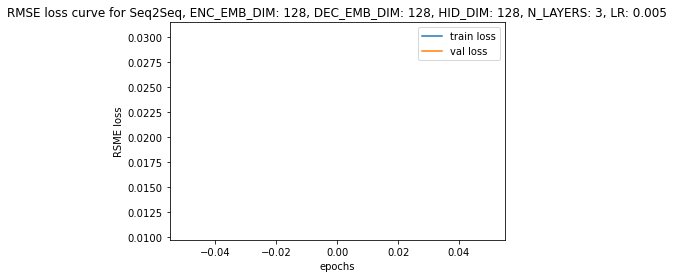

  1%|          | 1/100 [04:18<7:06:30, 258.49s/it]
0it [00:00, ?it/s]
1it [00:00,  1.68it/s]
2it [00:01,  1.64it/s]
3it [00:01,  1.69it/s]
4it [00:02,  1.71it/s]
5it [00:02,  1.73it/s]
6it [00:03,  1.68it/s]
7it [00:04,  1.75it/s]
8it [00:04,  1.70it/s]
9it [00:05,  1.67it/s]
10it [00:05,  1.62it/s]
11it [00:06,  1.58it/s]
12it [00:07,  1.56it/s]
13it [00:07,  1.54it/s]
14it [00:08,  1.53it/s]
15it [00:09,  1.53it/s]
16it [00:09,  1.54it/s]
17it [00:10,  1.55it/s]
18it [00:13,  1.21s/it]
19it [00:13,  1.00s/it]
20it [00:14,  1.19it/s]
21it [00:14,  1.35it/s]
22it [00:15,  1.43it/s]
23it [00:15,  1.51it/s]
24it [00:16,  1.54it/s]
25it [00:17,  1.53it/s]
26it [00:17,  1.57it/s]
27it [00:18,  1.63it/s]
28it [00:18,  1.68it/s]
29it [00:19,  1.69it/s]
30it [00:19,  1.73it/s]
31it [00:20,  1.71it/s]
32it [00:21,  1.73it/s]
33it [00:21,  1.79it/s]
34it [00:22,  1.84it/s]
35it [00:22,  1.86it/s]
36it [00:23,  1.86it/s]
37it [00:23,  1.91it/s]
38it [00:24,  1.82it/s]
39it [00:24,  1.75it/s]
40i

294it [03:18,  1.52it/s]
295it [03:18,  1.51it/s]
296it [03:19,  1.51it/s]
297it [03:20,  1.51it/s]
298it [03:20,  1.49it/s]
299it [03:21,  1.43it/s]
300it [03:22,  1.42it/s]
301it [03:23,  1.44it/s]
302it [03:23,  1.41it/s]
303it [03:24,  1.40it/s]
304it [03:25,  1.39it/s]
305it [03:25,  1.42it/s]
306it [03:26,  1.49it/s]
307it [03:27,  1.50it/s]
308it [03:27,  1.48it/s]
309it [03:28,  1.45it/s]
310it [03:29,  1.49it/s]
311it [03:29,  1.46it/s]
312it [03:30,  1.55it/s]
313it [03:31,  1.63it/s]
314it [03:31,  1.63it/s]
315it [03:32,  1.54it/s]
316it [03:33,  1.47it/s]
317it [03:33,  1.39it/s]
318it [03:34,  1.36it/s]
319it [03:35,  1.37it/s]
320it [03:36,  1.37it/s]
321it [03:36,  1.38it/s]
322it [03:37,  1.38it/s]
323it [03:38,  1.39it/s]
324it [03:39,  1.40it/s]
325it [03:39,  1.36it/s]
326it [03:40,  1.34it/s]
327it [03:41,  1.36it/s]
328it [03:41,  1.42it/s]
329it [03:42,  1.41it/s]
330it [03:43,  1.37it/s]
331it [03:44,  1.36it/s]
332it [03:44,  1.33it/s]
333it [03:45,  1.32it/s]


Epoch 2 | T: 4.51 | Train RMSE: 0.01215 | Valid RMSE: 0.00947


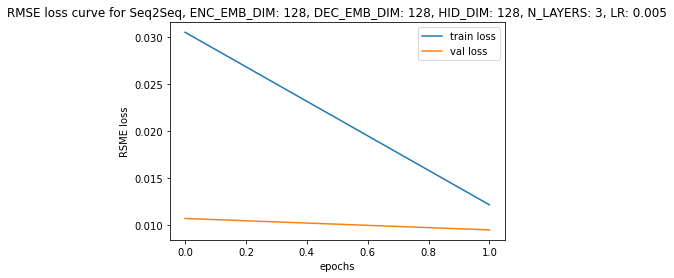

  2%|▏         | 2/100 [08:49<7:14:07, 265.79s/it]
0it [00:00, ?it/s]
1it [00:00,  1.68it/s]
2it [00:01,  1.61it/s]
3it [00:01,  1.56it/s]
4it [00:02,  1.50it/s]
5it [00:03,  1.47it/s]
6it [00:03,  1.47it/s]
7it [00:04,  1.48it/s]
8it [00:05,  1.47it/s]
9it [00:05,  1.50it/s]
10it [00:06,  1.49it/s]
11it [00:07,  1.47it/s]
12it [00:08,  1.48it/s]
13it [00:08,  1.52it/s]
14it [00:09,  1.57it/s]
15it [00:09,  1.62it/s]
16it [00:10,  1.57it/s]
17it [00:11,  1.59it/s]
18it [00:11,  1.60it/s]
19it [00:12,  1.64it/s]
20it [00:12,  1.64it/s]
21it [00:13,  1.60it/s]
22it [00:14,  1.56it/s]
23it [00:14,  1.55it/s]
24it [00:15,  1.50it/s]
25it [00:16,  1.50it/s]
26it [00:16,  1.49it/s]
27it [00:17,  1.45it/s]
28it [00:18,  1.46it/s]
29it [00:18,  1.52it/s]
30it [00:19,  1.59it/s]
31it [00:20,  1.58it/s]
32it [00:20,  1.57it/s]
33it [00:21,  1.66it/s]
34it [00:21,  1.75it/s]
35it [00:22,  1.76it/s]
36it [00:22,  1.75it/s]
37it [00:23,  1.73it/s]
38it [00:24,  1.73it/s]
39it [00:24,  1.73it/s]
40i

294it [03:24,  1.53it/s]
295it [03:25,  1.52it/s]
296it [03:25,  1.56it/s]
297it [03:26,  1.58it/s]
298it [03:27,  1.58it/s]
299it [03:27,  1.56it/s]
300it [03:28,  1.56it/s]
301it [03:29,  1.58it/s]
302it [03:29,  1.57it/s]
303it [03:30,  1.55it/s]
304it [03:31,  1.57it/s]
305it [03:31,  1.60it/s]
306it [03:32,  1.57it/s]
307it [03:32,  1.57it/s]
308it [03:33,  1.58it/s]
309it [03:34,  1.59it/s]
310it [03:34,  1.58it/s]
311it [03:35,  1.58it/s]
312it [03:36,  1.56it/s]
313it [03:36,  1.53it/s]
314it [03:37,  1.53it/s]
315it [03:38,  1.55it/s]
316it [03:38,  1.58it/s]
317it [03:39,  1.61it/s]
318it [03:39,  1.64it/s]
319it [03:40,  1.59it/s]
320it [03:41,  1.46it/s]
321it [03:42,  1.41it/s]
322it [03:42,  1.49it/s]
323it [03:43,  1.56it/s]
324it [03:43,  1.59it/s]
325it [03:44,  1.58it/s]
326it [03:45,  1.62it/s]
327it [03:45,  1.67it/s]
328it [03:46,  1.72it/s]
329it [03:46,  1.70it/s]
330it [03:47,  1.67it/s]
331it [03:48,  1.68it/s]
332it [03:48,  1.67it/s]
333it [03:49,  1.65it/s]


Epoch 3 | T: 4.55 | Train RMSE: 0.01035 | Valid RMSE: 0.00898


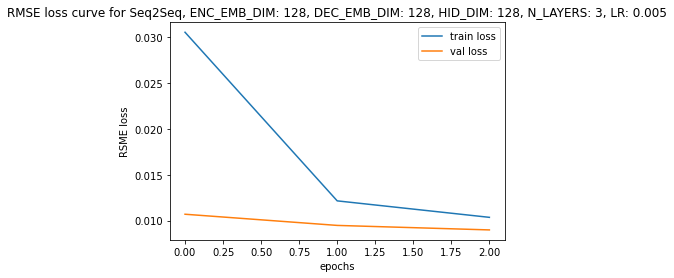

  3%|▎         | 3/100 [13:22<7:15:04, 269.12s/it]
0it [00:00, ?it/s]
1it [00:00,  1.58it/s]
2it [00:01,  1.61it/s]
3it [00:01,  1.59it/s]
4it [00:02,  1.57it/s]
5it [00:03,  1.56it/s]
6it [00:03,  1.57it/s]
7it [00:04,  1.58it/s]
8it [00:05,  1.58it/s]
9it [00:05,  1.65it/s]
10it [00:06,  1.65it/s]
11it [00:06,  1.60it/s]
12it [00:07,  1.63it/s]
13it [00:08,  1.60it/s]
14it [00:10,  1.04s/it]
15it [00:10,  1.08it/s]
16it [00:11,  1.17it/s]
17it [00:12,  1.28it/s]
18it [00:12,  1.35it/s]
19it [00:13,  1.43it/s]
20it [00:13,  1.52it/s]
21it [00:14,  1.64it/s]
22it [00:14,  1.67it/s]
23it [00:15,  1.64it/s]
24it [00:16,  1.60it/s]
25it [00:16,  1.60it/s]
26it [00:17,  1.63it/s]
27it [00:18,  1.68it/s]
28it [00:18,  1.78it/s]
29it [00:19,  1.81it/s]
30it [00:19,  1.73it/s]
31it [00:20,  1.65it/s]
32it [00:21,  1.60it/s]
33it [00:21,  1.56it/s]
34it [00:22,  1.53it/s]
35it [00:23,  1.51it/s]
36it [00:23,  1.53it/s]
37it [00:24,  1.64it/s]
38it [00:24,  1.56it/s]
39it [00:25,  1.56it/s]
40i

294it [03:12,  1.67it/s]
295it [03:13,  1.65it/s]
296it [03:14,  1.64it/s]
297it [03:14,  1.65it/s]
298it [03:15,  1.64it/s]
299it [03:15,  1.62it/s]
300it [03:16,  1.63it/s]
301it [03:17,  1.65it/s]
302it [03:17,  1.69it/s]
303it [03:18,  1.73it/s]
304it [03:18,  1.72it/s]
305it [03:19,  1.70it/s]
306it [03:20,  1.70it/s]
307it [03:20,  1.64it/s]
308it [03:21,  1.63it/s]
309it [03:22,  1.59it/s]
310it [03:22,  1.59it/s]
311it [03:23,  1.61it/s]
312it [03:23,  1.62it/s]
313it [03:24,  1.60it/s]
314it [03:25,  1.52it/s]
315it [03:25,  1.46it/s]
316it [03:26,  1.47it/s]
317it [03:27,  1.53it/s]
318it [03:27,  1.61it/s]
319it [03:28,  1.64it/s]
320it [03:29,  1.54it/s]
321it [03:29,  1.56it/s]
322it [03:30,  1.56it/s]
323it [03:30,  1.61it/s]
324it [03:31,  1.65it/s]
325it [03:32,  1.62it/s]
326it [03:32,  1.59it/s]
327it [03:33,  1.55it/s]
328it [03:34,  1.57it/s]
329it [03:34,  1.57it/s]
330it [03:35,  1.52it/s]
331it [03:36,  1.50it/s]
332it [03:36,  1.51it/s]
333it [03:37,  1.43it/s]


Epoch 4 | T: 4.39 | Train RMSE: 0.00991 | Valid RMSE: 0.00889


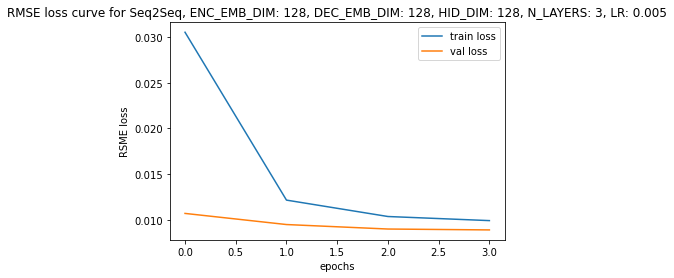

  4%|▍         | 4/100 [17:46<7:07:15, 267.03s/it]
0it [00:00, ?it/s]
1it [00:00,  1.88it/s]
2it [00:01,  1.95it/s]
3it [00:01,  1.86it/s]
4it [00:02,  1.76it/s]
5it [00:02,  1.68it/s]
6it [00:03,  1.59it/s]
7it [00:04,  1.58it/s]
8it [00:04,  1.55it/s]
9it [00:05,  1.55it/s]
10it [00:06,  1.54it/s]
11it [00:06,  1.56it/s]
12it [00:07,  1.58it/s]
13it [00:08,  1.56it/s]
14it [00:08,  1.58it/s]
15it [00:09,  1.61it/s]
16it [00:09,  1.62it/s]
17it [00:10,  1.67it/s]
18it [00:10,  1.74it/s]
19it [00:11,  1.66it/s]
20it [00:12,  1.61it/s]
21it [00:12,  1.58it/s]
22it [00:13,  1.55it/s]
23it [00:14,  1.53it/s]
24it [00:14,  1.55it/s]
25it [00:15,  1.56it/s]
26it [00:16,  1.59it/s]
27it [00:16,  1.63it/s]
28it [00:17,  1.64it/s]
29it [00:17,  1.67it/s]
30it [00:18,  1.70it/s]
31it [00:19,  1.71it/s]
32it [00:19,  1.71it/s]
33it [00:20,  1.67it/s]
34it [00:20,  1.68it/s]
35it [00:21,  1.69it/s]
36it [00:22,  1.70it/s]
37it [00:22,  1.64it/s]
38it [00:23,  1.64it/s]
39it [00:23,  1.61it/s]
40i

294it [03:24,  1.31it/s]
295it [03:25,  1.34it/s]
296it [03:25,  1.35it/s]
297it [03:26,  1.37it/s]
298it [03:27,  1.44it/s]
299it [03:27,  1.49it/s]
300it [03:28,  1.50it/s]
301it [03:29,  1.54it/s]
302it [03:29,  1.55it/s]
303it [03:30,  1.56it/s]
304it [03:30,  1.57it/s]
305it [03:31,  1.57it/s]
306it [03:32,  1.57it/s]
307it [03:32,  1.56it/s]
308it [03:33,  1.57it/s]
309it [03:34,  1.56it/s]
310it [03:34,  1.54it/s]
311it [03:35,  1.50it/s]
312it [03:36,  1.44it/s]
313it [03:36,  1.43it/s]
314it [03:37,  1.40it/s]
315it [03:38,  1.40it/s]
316it [03:39,  1.38it/s]
317it [03:39,  1.40it/s]
318it [03:40,  1.37it/s]
319it [03:41,  1.35it/s]
320it [03:42,  1.37it/s]
321it [03:42,  1.35it/s]
322it [03:43,  1.36it/s]
323it [03:44,  1.35it/s]
324it [03:45,  1.36it/s]
325it [03:46,  1.24it/s]
326it [03:46,  1.28it/s]
327it [03:47,  1.35it/s]
328it [03:48,  1.40it/s]
329it [03:48,  1.44it/s]
330it [03:49,  1.49it/s]
331it [03:49,  1.50it/s]
332it [03:50,  1.52it/s]
333it [03:51,  1.55it/s]


Epoch 5 | T: 4.58 | Train RMSE: 0.00919 | Valid RMSE: 0.00805


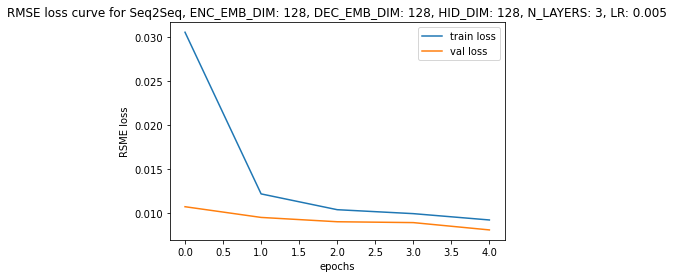

  5%|▌         | 5/100 [22:21<7:07:31, 270.02s/it]
0it [00:00, ?it/s]
1it [00:00,  1.98it/s]
2it [00:01,  1.97it/s]
3it [00:01,  1.88it/s]
4it [00:02,  1.72it/s]
5it [00:02,  1.67it/s]
6it [00:03,  1.64it/s]
7it [00:04,  1.63it/s]
8it [00:04,  1.61it/s]
9it [00:05,  1.60it/s]
10it [00:05,  1.62it/s]
11it [00:06,  1.69it/s]
12it [00:07,  1.70it/s]
13it [00:07,  1.69it/s]
14it [00:08,  1.68it/s]
15it [00:08,  1.70it/s]
16it [00:09,  1.73it/s]
17it [00:09,  1.75it/s]
18it [00:10,  1.77it/s]
19it [00:12,  1.06s/it]
20it [00:13,  1.08it/s]
21it [00:14,  1.19it/s]
22it [00:14,  1.26it/s]
23it [00:15,  1.31it/s]
24it [00:16,  1.34it/s]
25it [00:16,  1.42it/s]
26it [00:17,  1.51it/s]
27it [00:17,  1.58it/s]
28it [00:18,  1.61it/s]
29it [00:19,  1.62it/s]
30it [00:19,  1.61it/s]
31it [00:20,  1.55it/s]
32it [00:21,  1.52it/s]
33it [00:21,  1.47it/s]
34it [00:22,  1.48it/s]
35it [00:23,  1.46it/s]
36it [00:23,  1.47it/s]
37it [00:24,  1.48it/s]
38it [00:25,  1.46it/s]
39it [00:25,  1.50it/s]
40i

294it [03:21,  1.43it/s]
295it [03:22,  1.44it/s]
296it [03:23,  1.43it/s]
297it [03:23,  1.42it/s]
298it [03:24,  1.43it/s]
299it [03:25,  1.42it/s]
300it [03:25,  1.45it/s]
301it [03:26,  1.48it/s]
302it [03:27,  1.49it/s]
303it [03:27,  1.50it/s]
304it [03:28,  1.45it/s]
305it [03:29,  1.43it/s]
306it [03:29,  1.44it/s]
307it [03:30,  1.44it/s]
308it [03:31,  1.45it/s]
309it [03:31,  1.51it/s]
310it [03:32,  1.55it/s]
311it [03:33,  1.53it/s]
312it [03:33,  1.53it/s]
313it [03:34,  1.48it/s]
314it [03:35,  1.43it/s]
315it [03:36,  1.41it/s]
316it [03:36,  1.41it/s]
317it [03:37,  1.40it/s]
318it [03:38,  1.41it/s]
319it [03:38,  1.43it/s]
320it [03:39,  1.52it/s]
321it [03:40,  1.56it/s]
322it [03:40,  1.64it/s]
323it [03:41,  1.64it/s]
324it [03:41,  1.62it/s]
325it [03:42,  1.61it/s]
326it [03:43,  1.56it/s]
327it [03:43,  1.62it/s]
328it [03:44,  1.63it/s]
329it [03:44,  1.55it/s]
330it [03:45,  1.50it/s]
331it [03:46,  1.46it/s]
332it [03:47,  1.40it/s]
333it [03:47,  1.41it/s]


Epoch 6 | T: 4.54 | Train RMSE: 0.00905 | Valid RMSE: 0.00806


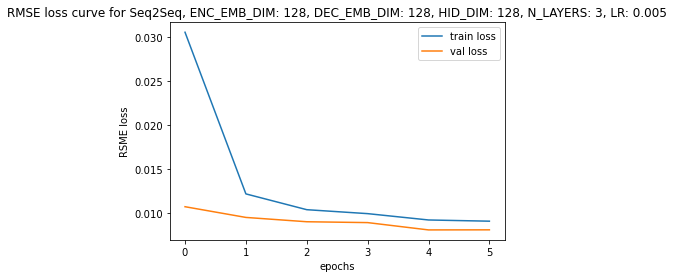

  6%|▌         | 6/100 [26:54<7:04:17, 270.82s/it]
0it [00:00, ?it/s]
1it [00:00,  1.49it/s]
2it [00:01,  1.47it/s]
3it [00:02,  1.47it/s]
4it [00:02,  1.52it/s]
5it [00:03,  1.60it/s]
6it [00:03,  1.64it/s]
7it [00:04,  1.65it/s]
8it [00:04,  1.73it/s]
9it [00:05,  1.78it/s]
10it [00:06,  1.76it/s]
11it [00:06,  1.75it/s]
12it [00:07,  1.74it/s]
13it [00:07,  1.75it/s]
14it [00:08,  1.74it/s]
15it [00:08,  1.71it/s]
16it [00:09,  1.65it/s]
17it [00:10,  1.61it/s]
18it [00:10,  1.56it/s]
19it [00:11,  1.55it/s]
20it [00:12,  1.52it/s]
21it [00:12,  1.53it/s]
22it [00:13,  1.56it/s]
23it [00:14,  1.53it/s]
24it [00:14,  1.51it/s]
25it [00:15,  1.51it/s]
26it [00:16,  1.52it/s]
27it [00:16,  1.51it/s]
28it [00:17,  1.52it/s]
29it [00:18,  1.56it/s]
30it [00:18,  1.54it/s]
31it [00:19,  1.59it/s]
32it [00:20,  1.60it/s]
33it [00:20,  1.60it/s]
34it [00:21,  1.57it/s]
35it [00:22,  1.52it/s]
36it [00:22,  1.49it/s]
37it [00:23,  1.50it/s]
38it [00:23,  1.52it/s]
39it [00:24,  1.53it/s]
40i

294it [03:20,  1.57it/s]
295it [03:20,  1.56it/s]
296it [03:21,  1.51it/s]
297it [03:22,  1.49it/s]
298it [03:22,  1.50it/s]
299it [03:23,  1.51it/s]
300it [03:24,  1.49it/s]
301it [03:25,  1.46it/s]
302it [03:25,  1.42it/s]
303it [03:26,  1.41it/s]
304it [03:27,  1.39it/s]
305it [03:27,  1.41it/s]
306it [03:28,  1.45it/s]
307it [03:29,  1.49it/s]
308it [03:29,  1.44it/s]
309it [03:30,  1.44it/s]
310it [03:31,  1.44it/s]
311it [03:32,  1.43it/s]
312it [03:32,  1.39it/s]
313it [03:33,  1.37it/s]
314it [03:34,  1.38it/s]
315it [03:35,  1.37it/s]
316it [03:35,  1.36it/s]
317it [03:36,  1.34it/s]
318it [03:37,  1.35it/s]
319it [03:38,  1.37it/s]
320it [03:38,  1.42it/s]
321it [03:39,  1.47it/s]
322it [03:40,  1.29it/s]
323it [03:40,  1.37it/s]
324it [03:41,  1.43it/s]
325it [03:42,  1.43it/s]
326it [03:42,  1.42it/s]
327it [03:43,  1.45it/s]
328it [03:44,  1.46it/s]
329it [03:44,  1.48it/s]
330it [03:45,  1.45it/s]
331it [03:46,  1.45it/s]
332it [03:47,  1.46it/s]
333it [03:47,  1.45it/s]


Epoch 7 | T: 4.49 | Train RMSE: 0.00901 | Valid RMSE: 0.00888


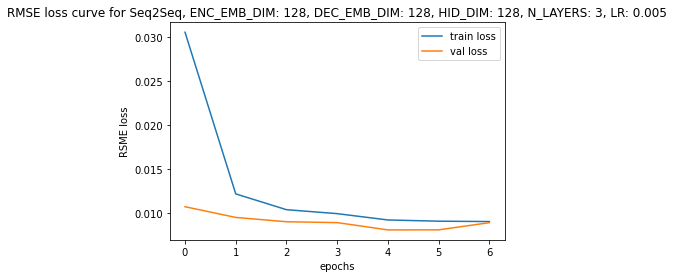

  7%|▋         | 7/100 [31:23<6:59:18, 270.52s/it]
0it [00:00, ?it/s]
1it [00:00,  1.94it/s]
2it [00:01,  1.96it/s]
3it [00:01,  1.88it/s]
4it [00:02,  1.91it/s]
5it [00:02,  1.89it/s]
6it [00:03,  1.91it/s]
7it [00:03,  1.93it/s]
8it [00:04,  1.87it/s]
9it [00:04,  1.88it/s]
10it [00:05,  1.83it/s]
11it [00:05,  1.82it/s]
12it [00:06,  1.76it/s]
13it [00:07,  1.75it/s]
14it [00:07,  1.73it/s]
15it [00:08,  1.71it/s]
16it [00:08,  1.72it/s]
17it [00:09,  1.75it/s]
18it [00:11,  1.01it/s]
19it [00:11,  1.16it/s]
20it [00:12,  1.29it/s]
21it [00:13,  1.38it/s]
22it [00:13,  1.46it/s]
23it [00:14,  1.52it/s]
24it [00:14,  1.59it/s]
25it [00:15,  1.68it/s]
26it [00:15,  1.76it/s]
27it [00:16,  1.76it/s]
28it [00:17,  1.75it/s]
29it [00:17,  1.70it/s]
30it [00:18,  1.69it/s]
31it [00:18,  1.67it/s]
32it [00:19,  1.68it/s]
33it [00:20,  1.67it/s]
34it [00:20,  1.67it/s]
35it [00:21,  1.68it/s]
36it [00:21,  1.65it/s]
37it [00:22,  1.70it/s]
38it [00:22,  1.73it/s]
39it [00:23,  1.72it/s]
40i

294it [03:18,  1.58it/s]
295it [03:18,  1.61it/s]
296it [03:19,  1.64it/s]
297it [03:19,  1.65it/s]
298it [03:20,  1.62it/s]
299it [03:21,  1.62it/s]
300it [03:21,  1.62it/s]
301it [03:22,  1.62it/s]
302it [03:23,  1.60it/s]
303it [03:23,  1.57it/s]
304it [03:24,  1.59it/s]
305it [03:24,  1.60it/s]
306it [03:25,  1.66it/s]
307it [03:26,  1.62it/s]
308it [03:26,  1.61it/s]
309it [03:27,  1.54it/s]
310it [03:28,  1.54it/s]
311it [03:28,  1.54it/s]
312it [03:29,  1.55it/s]
313it [03:30,  1.54it/s]
314it [03:30,  1.54it/s]
315it [03:31,  1.52it/s]
316it [03:32,  1.52it/s]
317it [03:32,  1.60it/s]
318it [03:33,  1.60it/s]
319it [03:33,  1.62it/s]
320it [03:34,  1.63it/s]
321it [03:35,  1.66it/s]
322it [03:35,  1.61it/s]
323it [03:36,  1.63it/s]
324it [03:37,  1.55it/s]
325it [03:37,  1.55it/s]
326it [03:38,  1.51it/s]
327it [03:39,  1.51it/s]
328it [03:39,  1.53it/s]
329it [03:40,  1.52it/s]
330it [03:41,  1.50it/s]
331it [03:41,  1.51it/s]
332it [03:42,  1.51it/s]
333it [03:42,  1.52it/s]


Epoch 8 | T: 4.43 | Train RMSE: 0.00841 | Valid RMSE: 0.00925


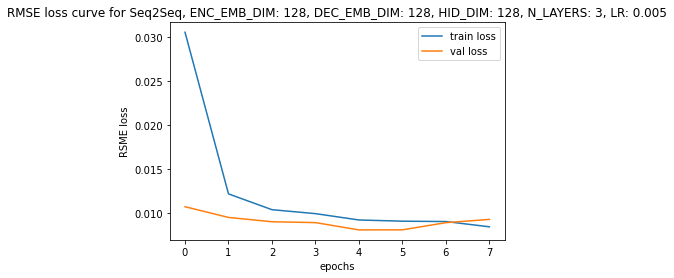

  8%|▊         | 8/100 [35:49<6:52:37, 269.10s/it]
0it [00:00, ?it/s]
1it [00:00,  1.60it/s]
2it [00:01,  1.66it/s]
3it [00:01,  1.68it/s]
4it [00:02,  1.68it/s]
5it [00:02,  1.69it/s]
6it [00:03,  1.71it/s]
7it [00:04,  1.77it/s]
8it [00:04,  1.79it/s]
9it [00:05,  1.77it/s]
10it [00:05,  1.69it/s]
11it [00:06,  1.63it/s]
12it [00:07,  1.61it/s]
13it [00:07,  1.59it/s]
14it [00:08,  1.66it/s]
15it [00:08,  1.72it/s]
16it [00:09,  1.74it/s]
17it [00:09,  1.77it/s]
18it [00:10,  1.76it/s]
19it [00:11,  1.77it/s]
20it [00:11,  1.79it/s]
21it [00:12,  1.83it/s]
22it [00:12,  1.85it/s]
23it [00:13,  1.82it/s]
24it [00:13,  1.82it/s]
25it [00:14,  1.79it/s]
26it [00:14,  1.79it/s]
27it [00:15,  1.84it/s]
28it [00:16,  1.79it/s]
29it [00:16,  1.75it/s]
30it [00:17,  1.76it/s]
31it [00:17,  1.79it/s]
32it [00:18,  1.79it/s]
33it [00:18,  1.76it/s]
34it [00:19,  1.70it/s]
35it [00:20,  1.69it/s]
36it [00:20,  1.66it/s]
37it [00:21,  1.66it/s]
38it [00:21,  1.69it/s]
39it [00:22,  1.72it/s]
40i

294it [03:14,  1.40it/s]
295it [03:14,  1.39it/s]
296it [03:15,  1.37it/s]
297it [03:16,  1.42it/s]
298it [03:16,  1.47it/s]
299it [03:17,  1.49it/s]
300it [03:18,  1.50it/s]
301it [03:18,  1.50it/s]
302it [03:19,  1.50it/s]
303it [03:20,  1.52it/s]
304it [03:20,  1.55it/s]
305it [03:21,  1.50it/s]
306it [03:22,  1.51it/s]
307it [03:22,  1.50it/s]
308it [03:23,  1.52it/s]
309it [03:24,  1.55it/s]
310it [03:24,  1.54it/s]
311it [03:25,  1.53it/s]
312it [03:26,  1.56it/s]
313it [03:26,  1.54it/s]
314it [03:27,  1.50it/s]
315it [03:28,  1.52it/s]
316it [03:28,  1.55it/s]
317it [03:29,  1.58it/s]
318it [03:29,  1.58it/s]
319it [03:30,  1.57it/s]
320it [03:31,  1.56it/s]
321it [03:31,  1.54it/s]
322it [03:32,  1.53it/s]
323it [03:33,  1.52it/s]
324it [03:33,  1.49it/s]
325it [03:34,  1.52it/s]
326it [03:35,  1.54it/s]
327it [03:35,  1.52it/s]
328it [03:36,  1.50it/s]
329it [03:37,  1.48it/s]
330it [03:37,  1.48it/s]
331it [03:38,  1.49it/s]
332it [03:39,  1.50it/s]
333it [03:39,  1.50it/s]


Epoch 9 | T: 4.38 | Train RMSE: 0.00908 | Valid RMSE: 0.00769


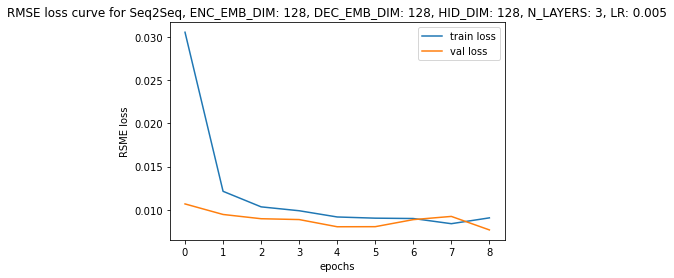

  9%|▉         | 9/100 [40:13<6:45:17, 267.23s/it]
0it [00:00, ?it/s]
1it [00:00,  2.07it/s]
2it [00:00,  2.10it/s]
3it [00:01,  1.91it/s]
4it [00:02,  1.93it/s]
5it [00:02,  1.94it/s]
6it [00:03,  1.93it/s]
7it [00:03,  1.85it/s]
8it [00:04,  1.78it/s]
9it [00:04,  1.76it/s]
10it [00:05,  1.75it/s]
11it [00:06,  1.74it/s]
12it [00:06,  1.66it/s]
13it [00:07,  1.61it/s]
14it [00:07,  1.58it/s]
15it [00:08,  1.60it/s]
16it [00:09,  1.62it/s]
17it [00:09,  1.63it/s]
18it [00:10,  1.69it/s]
19it [00:10,  1.77it/s]
20it [00:11,  1.75it/s]
21it [00:12,  1.71it/s]
22it [00:12,  1.73it/s]
23it [00:13,  1.77it/s]
24it [00:13,  1.77it/s]
25it [00:14,  1.72it/s]
26it [00:14,  1.78it/s]
27it [00:15,  1.83it/s]
28it [00:15,  1.82it/s]
29it [00:16,  1.80it/s]
30it [00:17,  1.74it/s]
31it [00:17,  1.67it/s]
32it [00:18,  1.67it/s]
33it [00:19,  1.61it/s]
34it [00:19,  1.55it/s]
35it [00:20,  1.61it/s]
36it [00:20,  1.64it/s]
37it [00:21,  1.63it/s]
38it [00:26,  1.80s/it]
39it [00:26,  1.44s/it]
40i

294it [03:12,  1.55it/s]
295it [03:13,  1.53it/s]
296it [03:13,  1.56it/s]
297it [03:14,  1.58it/s]
298it [03:15,  1.55it/s]
299it [03:15,  1.53it/s]
300it [03:16,  1.53it/s]
301it [03:17,  1.50it/s]
302it [03:17,  1.46it/s]
303it [03:18,  1.45it/s]
304it [03:19,  1.47it/s]
305it [03:19,  1.44it/s]
306it [03:20,  1.47it/s]
307it [03:21,  1.46it/s]
308it [03:21,  1.47it/s]
309it [03:22,  1.33it/s]
310it [03:23,  1.37it/s]
311it [03:24,  1.41it/s]
312it [03:24,  1.48it/s]
313it [03:25,  1.49it/s]
314it [03:26,  1.49it/s]
315it [03:26,  1.53it/s]
316it [03:27,  1.55it/s]
317it [03:28,  1.53it/s]
318it [03:28,  1.51it/s]
319it [03:29,  1.49it/s]
320it [03:30,  1.49it/s]
321it [03:30,  1.48it/s]
322it [03:31,  1.47it/s]
323it [03:32,  1.50it/s]
324it [03:32,  1.47it/s]
325it [03:33,  1.48it/s]
326it [03:34,  1.46it/s]
327it [03:34,  1.50it/s]
328it [03:35,  1.47it/s]
329it [03:36,  1.49it/s]
330it [03:36,  1.54it/s]
331it [03:37,  1.62it/s]
332it [03:37,  1.70it/s]
333it [03:38,  1.69it/s]


Epoch 10 | T: 4.37 | Train RMSE: 0.00839 | Valid RMSE: 0.00885


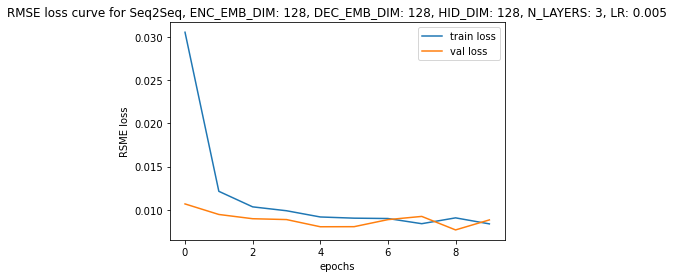

 10%|█         | 10/100 [44:35<6:38:42, 265.80s/it]
0it [00:00, ?it/s]
1it [00:00,  1.19it/s]
2it [00:01,  1.51it/s]
3it [00:01,  1.66it/s]
4it [00:02,  1.70it/s]
5it [00:03,  1.68it/s]
6it [00:03,  1.67it/s]
7it [00:04,  1.66it/s]
8it [00:04,  1.62it/s]
9it [00:05,  1.61it/s]
10it [00:06,  1.59it/s]
11it [00:06,  1.60it/s]
12it [00:07,  1.63it/s]
13it [00:08,  1.65it/s]
14it [00:08,  1.71it/s]
15it [00:09,  1.71it/s]
16it [00:09,  1.75it/s]
17it [00:10,  1.72it/s]
18it [00:10,  1.73it/s]
19it [00:11,  1.76it/s]
20it [00:12,  1.70it/s]
21it [00:12,  1.68it/s]
22it [00:13,  1.65it/s]
23it [00:13,  1.69it/s]
24it [00:14,  1.65it/s]
25it [00:15,  1.61it/s]
26it [00:15,  1.62it/s]
27it [00:16,  1.65it/s]
28it [00:16,  1.63it/s]
29it [00:17,  1.66it/s]
30it [00:18,  1.63it/s]
31it [00:18,  1.59it/s]
32it [00:19,  1.56it/s]
33it [00:20,  1.54it/s]
34it [00:20,  1.52it/s]
35it [00:21,  1.56it/s]
36it [00:22,  1.59it/s]
37it [00:22,  1.60it/s]
38it [00:23,  1.59it/s]
39it [00:23,  1.62it/s]
40

294it [03:30,  1.38it/s]
295it [03:30,  1.41it/s]
296it [03:31,  1.45it/s]
297it [03:32,  1.47it/s]
298it [03:32,  1.46it/s]
299it [03:33,  1.50it/s]
300it [03:34,  1.50it/s]
301it [03:34,  1.53it/s]
302it [03:35,  1.52it/s]
303it [03:36,  1.48it/s]
304it [03:36,  1.51it/s]
305it [03:37,  1.52it/s]
306it [03:38,  1.49it/s]
307it [03:38,  1.51it/s]
308it [03:39,  1.49it/s]
309it [03:40,  1.49it/s]
310it [03:40,  1.46it/s]
311it [03:41,  1.42it/s]
312it [03:42,  1.38it/s]
313it [03:43,  1.36it/s]
314it [03:43,  1.36it/s]
315it [03:44,  1.37it/s]
316it [03:45,  1.34it/s]
317it [03:46,  1.30it/s]
318it [03:47,  1.28it/s]
319it [03:47,  1.29it/s]
320it [03:48,  1.30it/s]
321it [03:49,  1.33it/s]
322it [03:50,  1.33it/s]
323it [03:50,  1.34it/s]
324it [03:51,  1.37it/s]
325it [03:52,  1.37it/s]
326it [03:53,  1.32it/s]
327it [03:53,  1.31it/s]
328it [03:54,  1.31it/s]
329it [03:55,  1.35it/s]
330it [03:55,  1.40it/s]
331it [03:56,  1.45it/s]
332it [03:57,  1.43it/s]
333it [03:57,  1.41it/s]


Epoch 11 | T: 4.71 | Train RMSE: 0.00868 | Valid RMSE: 0.00760


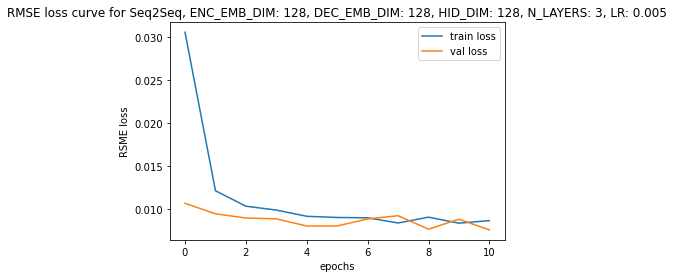

 11%|█         | 11/100 [49:18<6:41:57, 270.99s/it]
0it [00:00, ?it/s]
1it [00:00,  1.91it/s]
2it [00:01,  1.91it/s]
3it [00:01,  1.87it/s]
4it [00:02,  1.89it/s]
5it [00:02,  1.91it/s]
6it [00:03,  1.88it/s]
7it [00:03,  1.89it/s]
8it [00:04,  1.81it/s]
9it [00:04,  1.78it/s]
10it [00:05,  1.81it/s]
11it [00:05,  1.81it/s]
12it [00:06,  1.76it/s]
13it [00:07,  1.67it/s]
14it [00:07,  1.67it/s]
15it [00:08,  1.62it/s]
16it [00:09,  1.61it/s]
17it [00:09,  1.59it/s]
18it [00:10,  1.59it/s]
19it [00:11,  1.61it/s]
20it [00:11,  1.65it/s]
21it [00:12,  1.70it/s]
22it [00:12,  1.66it/s]
23it [00:13,  1.58it/s]
24it [00:14,  1.57it/s]
25it [00:14,  1.58it/s]
26it [00:15,  1.59it/s]
27it [00:15,  1.61it/s]
28it [00:16,  1.66it/s]
29it [00:17,  1.62it/s]
30it [00:17,  1.59it/s]
31it [00:21,  1.44s/it]
32it [00:21,  1.21s/it]
33it [00:22,  1.04s/it]
34it [00:23,  1.08it/s]
35it [00:23,  1.19it/s]
36it [00:24,  1.28it/s]
37it [00:25,  1.33it/s]
38it [00:25,  1.36it/s]
39it [00:26,  1.41it/s]
40

KeyboardInterrupt: 

In [57]:
train_losses = []
val_losses = []
min_loss = 10e8

for epoch in tqdm(range(N_EPOCHS)):
    start = time.time()
    
    train_loss = train(model, train_loader, optimizer, criterion)
    val_loss = eval(model, valid_loader, criterion)
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    
    # save the best model
    if val_losses[-1] < min_loss:
        min_loss = val_losses[-1] 
        best_model = model
    
    end = time.time()
    
    # Early Stopping
    if (len(train_losses) > 100 and np.mean(val_losses[-5:]) >= np.mean(val_losses[-10:-5])):
        break   
    
    # Learning Rate Decay        
    scheduler.step()
    
    print("Epoch {} | T: {:0.2f} | Train RMSE: {:0.5f} | Valid RMSE: {:0.5f}".format(epoch + 1, (end-start) / 60, train_loss, val_loss))
    
    plt.figure()
    plt.plot(train_losses, label="train loss")
    plt.plot(val_losses, label="val loss")
    plt.xlabel('epochs')
    plt.ylabel('RSME loss')
    plt.title(f'RMSE loss curve for Seq2Seq, ENC_EMB_DIM: {ENC_EMB_DIM}, DEC_EMB_DIM: {DEC_EMB_DIM}, HID_DIM: {HID_DIM}, N_LAYERS: {N_LAYERS}, LR: {LEARNING_RATE}')
    plt.legend()
    plt.savefig(f'transformer_loss_curve_v1_ENC_EMB_DIM_{ENC_EMB_DIM}_DEC_EMB_DIM_{DEC_EMB_DIM}_HID_DIM_{HID_DIM}_N_LAYERS_{N_LAYERS}_LR_{LEARNING_RATE}.png')
    plt.show()
    
torch.save(best_model.state_dict(), f'seq2seq_ENC_EMB_DIM_{ENC_EMB_DIM}_DEC_EMB_DIM_{DEC_EMB_DIM}_HID_DIM_{HID_DIM}_N_LAYERS_{N_LAYERS}_LR_{LEARNING_RATE}.pt')

In [58]:
torch.save(best_model.state_dict(), f'seq2seq_ENC_EMB_DIM_{ENC_EMB_DIM}_DEC_EMB_DIM_{DEC_EMB_DIM}_HID_DIM_{HID_DIM}_N_LAYERS_{N_LAYERS}_LR_{LEARNING_RATE}.pt')

In [60]:
test_path = "../val_in/val_in/"
test_pkl_list = glob(os.path.join(test_path, '*'))
test_pkl_list.sort()

test_preds = []
for idx in range(len(test_pkl_list)):
    with open(test_pkl_list[idx], 'rb') as f:
        test_sample = pickle.load(f)
        pred_id = np.where(test_sample["track_id"] == test_sample['agent_id'])[0][0]
        inp_scene = np.dstack([test_sample['p_in'], test_sample['v_in']])

        # Normalization 
        min_vecs = np.min(inp_scene, axis = (0,1))
        max_vecs = np.max(inp_scene, axis = (0,1))
        
        inp = (inp_scene[pred_id] - min_vecs)/(max_vecs - min_vecs)
        
        inp = torch.from_numpy(inp).float().to(device).unsqueeze(0)

        preds = best_model(inp).cpu().data.numpy()
        
        # De-Normalization ! 
        preds = preds * (max_vecs[:2] - min_vecs[:2]) +  min_vecs[:2]
        test_preds.append(preds)

TypeError: forward() missing 1 required positional argument: 'y'

In [45]:
a = np.array((1,2,3))

b = np.array((2,3,4))

c = np.dstack((a,b))

In [46]:
c

array([[[1, 2],
        [2, 3],
        [3, 4]]])

In [48]:
c.shape

(1, 3, 2)